In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
#import tflearn
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import sys
import operator
import pickle
import itertools

from numpy import linalg as la 

In [6]:
# parameters
data_path = '/content/drive/MyDrive/Colab Notebooks/Data/'
file_name = 'RML2016.10a_dict.pkl'

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
encoder_1 (LSTM)                [(None, 128, 32), (N 4480        encoder_inputs[0][0]             
__________________________________________________________________________________________________
drop_1 (Dropout)                (None, 128, 32)      0           encoder_1[0][0]                  
__________________________________________________________________________________________________
encoder_2 (LSTM)                [(None, 128, 32), (N 8320        drop_1[0][0]                     
____________________________________________________________________________________________

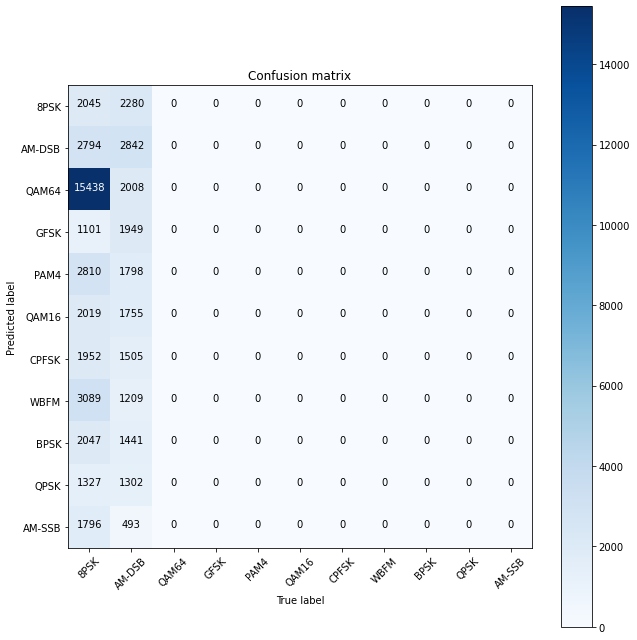

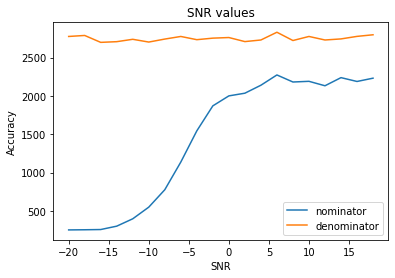

In [11]:
signal_len = 128
modulation_num = 11

def get_amp_phase(data):
    X_train_cmplx = data[:, 0, :] + 1j * data[:, 1, :]
    X_train_amp = np.abs(X_train_cmplx)
    X_train_ang = np.arctan2(data[:, 1, :], data[:, 0, :]) / np.pi
    X_train_amp = np.reshape(X_train_amp, (-1, 1, signal_len))
    X_train_ang = np.reshape(X_train_ang, (-1, 1, signal_len))
    X_train = np.concatenate((X_train_amp, X_train_ang), axis = 1) 
    X_train = np.transpose(np.array(X_train), (0, 2, 1))
    for i in range(X_train.shape[0]):
        X_train[i, :, 0] = X_train[i, :, 0] / np.linalg.norm(X_train[i, :, 0], 2)
    
    return X_train

def set_up_data(data_path, file_name):
    # import data
    with open(data_path + file_name, 'rb') as f:
        data = pickle.load(f, encoding = 'latin1')

    # get data in dictionary format (Modulaton -> SNR -> IQ)
    dic = {}
    for item in list(data):
        modulation = item[0]
        SNR = int(item[1])

        if modulation not in dic:
            dic[modulation] = {SNR : data[item]}
        elif SNR not in dic[modulation]:
            dic[modulation][SNR] = data[item]

    # build data in np array format
    len_feature = dic[list(dic)[0]][list(dic[list(dic)[0]])[0]][0].shape[1]
    data = np.empty((0, 2, len_feature), float) # 2 for IQ components
    label = []
    for modulation in dic:
        for snr in dic[modulation]:
            label.extend(list([modulation, snr] for _ in range(dic[modulation][snr].shape[0])))
            data = np.vstack((data, dic[modulation][snr]))

    label = np.array(label)
    index  = list(range(data.shape[0]))
    np.random.seed(2019)
    np.random.shuffle(index)

    train_proportion = 0.5
    validation_proportion = 0.25
    test_proportion = 0.25

    X_train = data[index[:int(data.shape[0] * train_proportion)], :, :]
    Y_train = label[index[:int(data.shape[0] * train_proportion)]]
    X_validation = data[index[int(data.shape[0] * train_proportion) : int(data.shape[0] * (train_proportion + validation_proportion))], :, :]
    Y_validation = label[index[int(data.shape[0] * train_proportion) : int(data.shape[0] * (train_proportion + validation_proportion))]]
    X_test = data[index[int(data.shape[0] * (train_proportion + validation_proportion)):], :, :]
    Y_test = label[index[int(data.shape[0] * (train_proportion + validation_proportion)):]]
    
    modulation_index = {}
    modulations = np.sort(list(dic))
    for i in range(len(list(dic))):
        modulation_index[modulations[i]] = i

    return X_train, Y_train, X_validation, Y_validation, X_test, Y_test, modulation_index

def zero_mask(X_train, p):
    num = int(X_train.shape[1] * p)
    res = X_train.copy()
    index = np.array([[i for i in range(X_train.shape[1])] for _ in range(X_train.shape[0])])
    for i in range(index.shape[0]):
        np.random.shuffle(index[i, :])
    
    for i in range(res.shape[0]):
        res[i, index[i, :num], :] = 0
        
    return res

# set up data
X_train, Y_train, X_validation, Y_validation, X_test, Y_test, modulation_index = set_up_data(data_path, file_name)

target_names=[]
for i in Y_test:
    if i[0] not in target_names:
        target_names.append(i[0])
     
    
for i in range(Y_train.shape[0]):
    Y_train[i, 0] = modulation_index[Y_train[i, 0]]
    
for i in range(Y_validation.shape[0]):
    Y_validation[i, 0] = modulation_index[Y_validation[i, 0]]

for i in range(Y_test.shape[0]):
    Y_test[i, 0] = modulation_index[Y_test[i, 0]] 
    
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
Y_train = Y_train.astype(int)
X_validation = X_validation.reshape((X_validation.shape[0], X_validation.shape[1], X_validation.shape[2]))
Y_validation = Y_validation.astype(int)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))
Y_test = Y_test.astype(int)

X_train = get_amp_phase(X_train)
X_validation = get_amp_phase(X_validation)
X_test = get_amp_phase(X_test)

encoder_inputs = tf.keras.Input(shape = (X_train.shape[1], X_train.shape[2]),
                                name = 'encoder_inputs')

encoder_1, state_h_1, state_c_1 = tf.keras.layers.LSTM(units = 32,
                                    return_sequences = True,
                                    return_state = True,
                                    name = 'encoder_1')(encoder_inputs)

drop_prob = 0
drop_1 = tf.keras.layers.Dropout(drop_prob, name = 'drop_1')(encoder_1)

encoder_2, state_h_2, state_c_2 = tf.keras.layers.LSTM(units = 32,
                                    return_state = True,
                                    return_sequences = True,                
                                    name = 'encoder_2')(drop_1)

decoder = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2),
                                          name = 'decoder')(encoder_2)

# 3 Dense layers for classification with bn
clf_dropout = 0

clf_dense_1 = tf.keras.layers.Dense(units = 32,
                                    activation = tf.nn.relu,
                                    name = 'clf_dense_1')(state_h_2)

bn_1 = tf.keras.layers.BatchNormalization(name = 'bn_1')(clf_dense_1)

clf_drop_1 = tf.keras.layers.Dropout(clf_dropout, name = 'clf_drop_1')(bn_1)

clf_dense_2 = tf.keras.layers.Dense(units = 16,
                                    activation = tf.nn.relu,
                                    name = 'clf_dense_2')(clf_drop_1)

bn_2 = tf.keras.layers.BatchNormalization(name = 'bn_2')(clf_dense_2)

clf_drop_2 = tf.keras.layers.Dropout(clf_dropout, name = 'clf_drop_2')(bn_2)

clf_dense_3 = tf.keras.layers.Dense(units = modulation_num,
                                    name = 'clf_dense_3')(clf_drop_2)

softmax = tf.keras.layers.Softmax(name = 'softmax')(clf_dense_3)

model = tf.keras.Model(inputs = encoder_inputs, outputs = [decoder, softmax])
model.summary()


learning_rate = 10 ** -3
lam = 0.1

model.compile(loss = ['mean_squared_error', 'categorical_crossentropy'],
              loss_weights = [1 - lam, lam],
              metrics=['accuracy'],
              optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate))

best = 0
train_acc = []
val_acc = []


for ite in range(30):
    X_train_masked = zero_mask(X_train, 0)
    print(ite)
    history = model.fit(x = X_train,
                        y = [X_train, tf.keras.utils.to_categorical(Y_train[:, 0])],
                        validation_data = (X_validation, [X_validation, tf.keras.utils.to_categorical(Y_validation[:, 0])]),
                        batch_size = 128,
                        epochs = 1)
    
    train_acc.append(history.history['softmax_accuracy'][0])
    val_acc.append(history.history['val_softmax_accuracy'][0])

    if history.history['val_softmax_accuracy'][0] > best:
        best = history.history['val_softmax_accuracy'][0]
        model.save('DAELSTM.h5')

    with open('val_result.txt', 'a') as f:
        f.write(str(history.history['val_softmax_accuracy'][0] * 100) + '\n')
        

clf = tf.keras.models.load_model('DAELSTM.h5')

res = clf.predict(X_test)[1]
res = np.argmax(res, axis = 1)


# Confusion matrix function
def plot_confusion_matrix(cm,target_names,normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')


# Compute confusion matrix

cm = confusion_matrix(res,np.argmax(Y_test,1))
np.set_printoptions(precision=3)
print('Confusion matrix, without normalization')
print(cm)
plt.figure(figsize=(9,9))
plot_confusion_matrix(cm,target_names)
plt.show()



test_accuracy = {}
for i in range(X_test.shape[0]):
    if Y_test[i, 1] not in test_accuracy:
        if Y_test[i, 0] == res[i]:
            test_accuracy[Y_test[i, 1]] = [1, 1]
        else:
            test_accuracy[Y_test[i, 1]] = [0, 1]
    else:
        if Y_test[i, 0] == res[i]:
            test_accuracy[Y_test[i, 1]][0] += 1
            test_accuracy[Y_test[i, 1]][1] += 1
        else:
            test_accuracy[Y_test[i, 1]][1] += 1

nomi = 0
deno = 0
for snr in test_accuracy:
    nomi += test_accuracy[snr][0]
    deno += test_accuracy[snr][1]

best = nomi / deno

with open('result.txt', 'a') as f:
    for item in [test_accuracy[i][0] / test_accuracy[i][1] for i in np.sort(list(test_accuracy))]:
        f.write(str(item * 100) + '\n')
        
    f.write(str(best * 100) + '\n')
    f.write('\n')

import collections
test_accuracy = collections.OrderedDict(sorted(test_accuracy.items()))

x=[]
for i in test_accuracy.keys():
    x.append(i)

lst=[]
lst2=[]
for i in test_accuracy.values():
    lst.append(i[0])
    lst2.append(i[1])

plt.plot(x, lst, label = "nominator")
plt.plot(x, lst2, label = "denominator")
plt.xlabel('SNR')
plt.ylabel('Accuracy')
plt.title('SNR values')

plt.legend()
plt.show()